# Extract the Throughput

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline


In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [3]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits',
 'comptable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits',
 'thermtable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [4]:
import time
from datetime import datetime,date
import dateutil.parser
import pytz

import logging
import coloredlogs

import coloredlogs
import configparser
import argparse


In [5]:
from scipy import interpolate
from scipy.interpolate import UnivariateSpline

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel,WhiteKernel)

# Initialisation

In [7]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')

In [8]:
# set time
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")

# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)

# timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
msg="LA time:"+  datetime_LA.strftime("%H:%M:%S")
logger.info(msg)

tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
msg="NY time:"+ datetime_NY.strftime("%H:%M:%S")
logger.info(msg)

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
msg="London time:"+ datetime_London.strftime("%H:%M:%S")
logger.info(msg)

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
msg="Paris time:"+ datetime_Paris.strftime("%H:%M:%S")
logger.info(msg)

msg="************************ START *********************"
logger.info(msg)


2020-10-01 16:20:43,103 MacBook-Pro-de-admin.local __main__[99198] INFO LA time:07:20:43
2020-10-01 16:20:43,106 MacBook-Pro-de-admin.local __main__[99198] INFO NY time:10:20:43
2020-10-01 16:20:43,109 MacBook-Pro-de-admin.local __main__[99198] INFO London time:15:20:43
2020-10-01 16:20:43,111 MacBook-Pro-de-admin.local __main__[99198] INFO Paris time:16:20:43
2020-10-01 16:20:43,111 MacBook-Pro-de-admin.local __main__[99198] INFO ************************ START *********************


In [9]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""

In [10]:
# config file
# --------------
configfile = "config/default.ini"
#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)


2020-10-01 16:20:43,127 MacBook-Pro-de-admin.local __main__[99198] INFO Configuration file : config/default.ini


# Configuration

In [11]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

2020-10-01 16:20:43,143 MacBook-Pro-de-admin.local __main__[99198] INFO 1) Configuration


In [12]:
config_section = config.sections()

In [13]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)

In [14]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(int(config['GENERAL']['FLAG_DEBUG']))
    FLAG_VERBOSE = bool(int(config['GENERAL']['FLAG_VERBOSE']))
    FLAG_PLOT   = bool(int(config['GENERAL']['FLAG_PLOT']))
    FLAG_PRINT  = bool(int(config['GENERAL']['FLAG_PRINT']))
    inputdir    = config['GENERAL']['inputdir']
    inputfile   = config['GENERAL']['inputfile']
    target      = config['GENERAL']['object']
    sedfilename = config['GENERAL']['sedfilename']
    WLMINSEL      = float(config['GENERAL']['WLMINSEL'])
    WLMAXSEL      = float(config['GENERAL']['WLMAXSEL'])
    normalisation_factor = float(config['GENERAL']['normalisation_factor'])
    NPOINTSVIEW       =    int(config['GENERAL']['NPOINTSVIEW']) 
    NPOINTSSAVE       =    int(config['GENERAL']['NPOINTSSAVE']) 
    outputfile_linearfit =  config['GENERAL']['outputfile_linearfit']
    outputfile_gp        =  config['GENERAL']['outputfile_gp']
    holodatadir      =  config['GENERAL']['holodatadir']
    

else:
    msg = f"Configuration file : empty section GENERAL in config file {config_filename} !"   
    logger.error(msg)

In [15]:
msg=f" Object observed {target}"
logger.info(msg)

2020-10-01 16:20:43,177 MacBook-Pro-de-admin.local __main__[99198] INFO  Object observed HD116405


In [16]:
# SELECT THE INPUT FILE
inputfilename = outputfile_linearfit
#inputfilename = outputfile_gp

# SED

In [17]:
s0=S.FileSpectrum(os.path.join(path_sed_calspec,sedfilename))
s0.convert('flam')

In [18]:
sed_w=s0.wave/10
sed_f=s0.flux*10
sed_idx=np.where(np.logical_and(sed_w>350,sed_w<1100))[0]
sed_w=sed_w[sed_idx]
sed_f=sed_f[sed_idx]

In [19]:
sed_m=-2.5*np.log10(sed_f)

Text(0.5, 1.0, 'SED')

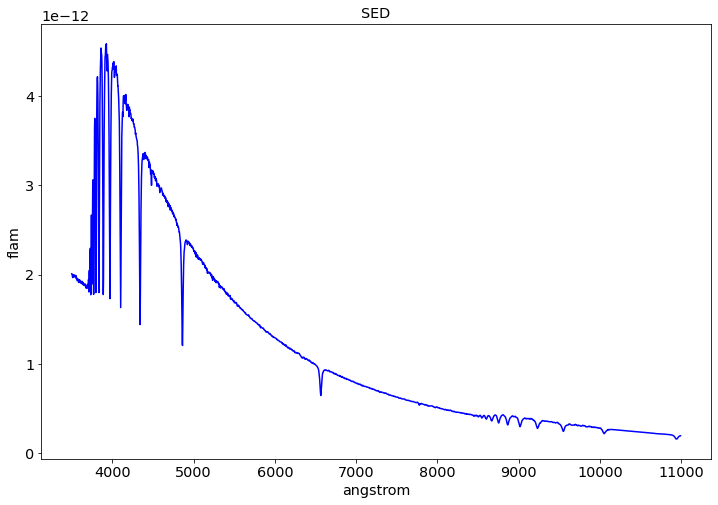

In [20]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(sed_w*10,sed_f/10,"b-")
ax.set_xlabel(s0.waveunits.name)
ax.set_ylabel(s0.fluxunits.name)
ax.set_title("SED")

# Holodata

In [21]:
list_of_files=os.listdir(holodatadir)

In [22]:
holo_files= []
for file in list_of_files:
    if re.search('.*holo.*[.txt]', file):
        holo_files.append(file)

In [23]:
holo_files=sorted(holo_files)

In [24]:
holo_files

['holo-2-1-order1.txt',
 'holo-2-2-order1.txt',
 'holo-2-4-order1.txt',
 'holo-3-100-1-order2_bis.txt',
 'holo-3-100-2-order0.txt',
 'holo-3-100-2-order1.txt',
 'holo-3-100-2-order2.txt',
 'holo-3-150-2-order0.txt',
 'holo-3-150-2-order1.txt',
 'holo-3-150-2-order1_bis.txt',
 'holo-3-150-2-order2.txt',
 'holo-3-200-1-order0.txt',
 'holo-3-200-1-order1.txt',
 'holo-3-200-1-order2.txt',
 'holo-3-70-2-order0.txt',
 'holo-3-70-2-order1.txt',
 'holo-3-70-2-order2.txt']

In [25]:
holodata1=np.loadtxt(os.path.join(holodatadir, holo_files[0]))
holodata2=np.loadtxt(os.path.join(holodatadir, holo_files[1]))
holodata3=np.loadtxt(os.path.join(holodatadir, holo_files[2]))
holodata4=np.loadtxt(os.path.join(holodatadir, holo_files[5]))
holodata5=np.loadtxt(os.path.join(holodatadir, holo_files[6]))

holotag1="holo-2-1 eff"
holotag2="holo-2-2 eff"
holotag3="holo-2-4 eff"
holotag4="holo-3-100-2-order1 eff"
holotag5="holo-3-100-2-order2 eff"

## Throughput data from scanned points

In [26]:
scandata_file="throughputdata/plotdigitizeddata_throughputbouguer.csv"

In [27]:
df_scan=pd.read_csv(scandata_file,header=2,index_col=False)

In [28]:
wl_scan=df_scan["wl"].values
thr_scan=df_scan["thr"].multiply(0.01).values

2020-10-01 16:20:43,582 MacBook-Pro-de-admin.local numexpr.utils[99198] INFO NumExpr defaulting to 8 threads.


### Make spline on scanned points

In [29]:
spl = UnivariateSpline(wl_scan, thr_scan)
spl_thr = UnivariateSpline(wl_scan, thr_scan)
#spl.set_smoothing_factor(10)

## throuputdata from bouguer lines

The file has been generated by **MLfit_bouguer_linearfit.ipynb** or **MLfit_bouguer_gp.ipynb**     

In [30]:
df=pd.read_csv(inputfilename,index_col=0)

In [31]:
# decode the data
Y0=df["throu"]
EY0=df["errthrou"]
wl0=df["wavelength"]

In [32]:
# make the spline curve for throughput
x_spl=np.linspace(wl0.min(),wl0.max(),200)
y_spl=spl_thr(x_spl)


## Plot

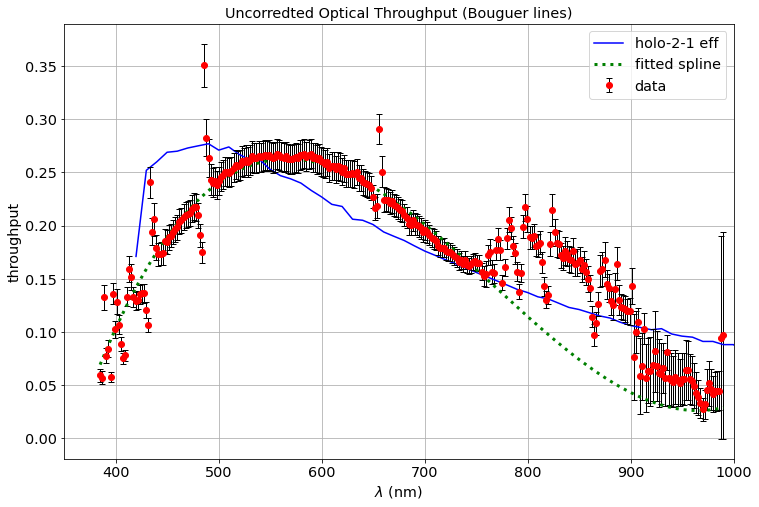

In [33]:
fig=plt.figure()
ax=fig.add_subplot(111)

# hologram data
ax.plot(holodata1[:,1],holodata1[:,2],"b-",label=holotag1 )
#ax.plot(holodata2[:,1],holodata2[:,2],"g-",label=holotag2 )
#ax.plot(holodata3[:,1],holodata3[:,2],"m-",label=holotag3 )
# plot other series
if 0:
    ax.plot(holodata4[:,1],holodata3[:,2],"g-",label=holotag4 )
    ax.plot(2*holodata5[:,1],holodata5[:,2],"m-",label=holotag5 )

# pic du midi throughput
ax.errorbar(wl0,Y0,yerr=EY0,  fmt = 'o', color="r",capsize = 3, ecolor = 'k', elinewidth = 1, capthick = 1,label="data")
#ax.errorbar(w_s,transm_s,yerr=em_s,  fmt = 'o', color="r",ecolor = 'k', elinewidth = 1)
#ax.plot(w,transm,"or")

ax.plot(x_spl,y_spl,":",color="g",lw=3,label="fitted spline")

ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("throughput")
title=f"Uncorredted Optical Throughput (Bouguer lines)"
ax.set_title(title)
ax.grid()
ax.legend()
ax.set_xlim(350,1000)
plt.show()

# Spectrum above the atmosphere

In [34]:
Y1=df["sedtoa"]
EY1=df["errsedtoa"]
wl1=df["wavelength"]

## Try to extract second order component from first order component

In [35]:
wl2_idx=np.where(np.logical_and(wl1>=WLMINSEL,wl1<=WLMAXSEL/2))[0]
wl2=wl1[wl2_idx]
Y2=Y1[wl2_idx]/2
EY2=EY1[wl2_idx]/2

In [36]:
fcn2 = interpolate.interp1d(2*wl2,Y2,bounds_error=False,fill_value=(0,0))
fcn2e = interpolate.interp1d(2*wl2,EY2,bounds_error=False,fill_value=(0,0))

In [37]:
Y2interp=fcn2(wl1) 
EY2interp=fcn2e(wl1) 

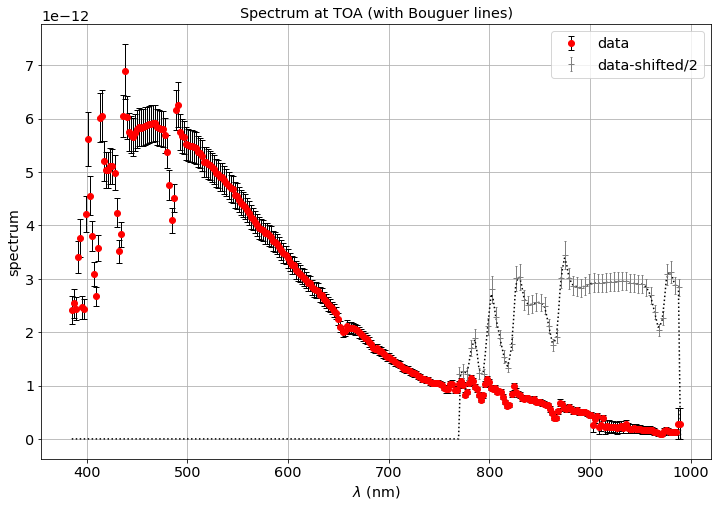

In [38]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.errorbar(wl1,Y1,yerr=EY1,  fmt = 'o', color="r",capsize = 3, ecolor = 'k', elinewidth = 1, capthick = 1,label="data")
#ax.errorbar(w_s,transm_s,yerr=em_s,  fmt = 'o', color="r",ecolor = 'k', elinewidth = 1)
#ax.plot(w,transm,"or")
ax.errorbar(2*wl2,Y2,yerr=EY2,  fmt = '+', color="grey",capsize = 1, ecolor = 'grey', elinewidth = 1, capthick = 1,label="data-shifted/2")
ax.plot(wl1,Y2interp,"k:")
#plt.plot(sed_w,sed_f,"b-",label="SED")
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("spectrum")
title=f"Spectrum at TOA (with Bouguer lines)"
ax.set_title(title)
ax.legend()
ax.grid()
#ax.set_yscale("log")

## try to extract the second order component from the shifted spline

### Make observation throuth the throughput splined

In [39]:
bp_order1 = S.ArrayBandpass(x_spl*10, y_spl, name='Bouguer throughput')

In [40]:
obs = S.Observation(s0, bp_order1, force='taper')  # order 1

(Bouguer throughput) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


(-6e-13, 6e-13)

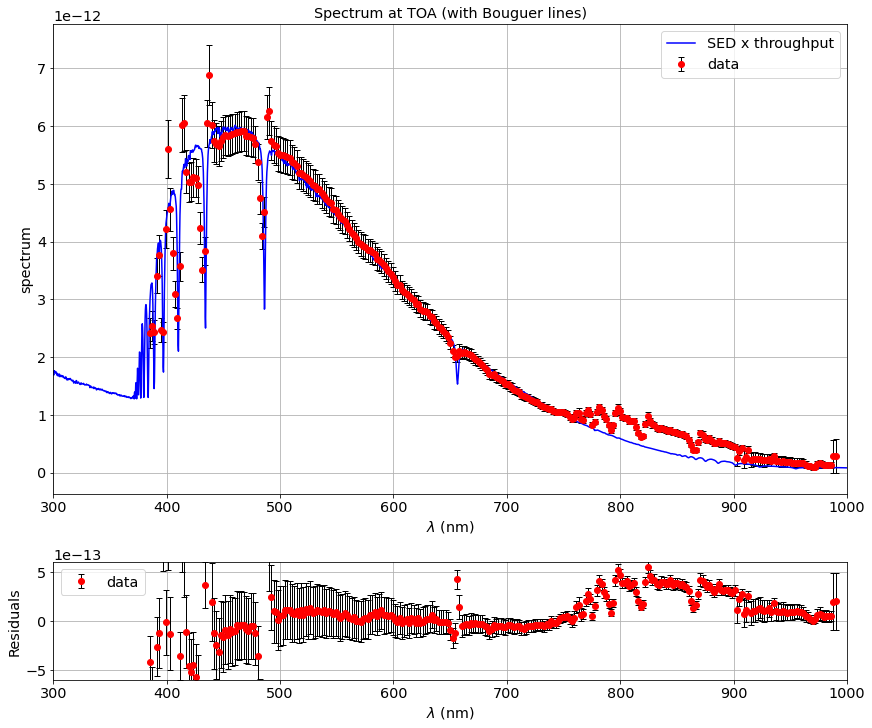

In [41]:
fig=plt.figure(figsize=(12,10),constrained_layout=True)


widths = [1,1]
heights = [4,1]
#spec = fig.add_gridspec(ncols=1, nrows=2, width_ratios=widths,height_ratios=heights)
spec = fig.add_gridspec(ncols=1, nrows=2, height_ratios=heights)

ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])

# top panel
ax1.errorbar(wl1,Y1,yerr=EY1,  fmt = 'o', color="r",capsize = 3, ecolor = 'k', elinewidth = 1, capthick = 1,label="data")

ax1.plot(obs.binwave/10, obs.binflux*10,"b-",label="SED x throughput")
ax1.set_xlabel("$\lambda$ (nm)")
ax1.set_ylabel("spectrum")
title=f"Spectrum at TOA (with Bouguer lines)"
ax1.set_title(title)
ax1.legend()
ax1.grid()
ax1.set_xlim(300,1000)
#ax.set_yscale("log")

# bottom panel

# interpolate the simulated spectrum

func_obs = interpolate.interp1d(obs.binwave/10, obs.binflux*10)

DeltaY1= Y1-func_obs(wl1) 
ax2.errorbar(wl1,DeltaY1,yerr=EY1,  fmt = 'o', color="r",capsize = 3, ecolor = 'k', elinewidth = 1, capthick = 1,label="data")
ax2.set_xlabel("$\lambda$ (nm)")
ax2.set_ylabel("Residuals")
title=f"residuals"
#ax2.set_title(title)
ax2.legend()
ax2.grid()
ax2.set_xlim(300,1000)
ax2.set_ylim(-0.6e-12,0.6e-12)

## Extract order 1 - order 2 component 

In [42]:
speco1_scanned_file="throughputdata/plotdigitizeddata_spec_toa_order1.csv"
speco2_scanned_file="throughputdata/plotdigitizeddata_spec_toa_order2.csv"

In [43]:
df_scan1=pd.read_csv(speco1_scanned_file,header=3,index_col=False)

In [44]:
# put the right scale
df_scan1["spec_o1"]=df_scan1["spec_o1"].multiply(1e-12)

In [45]:
df_scan2=pd.read_csv(speco2_scanned_file,header=3,index_col=False)

In [46]:
# put the right scale
df_scan2["spec_o2"]=df_scan2["spec_o2"].multiply(1e-13)

In [47]:
wl_scan1=df_scan1["wl"].values
flx_scan1=df_scan1["spec_o1"].values
spl_scan1 = UnivariateSpline(wl_scan1, flx_scan1)
fcn_scan1 = interpolate.interp1d(wl_scan1, flx_scan1,bounds_error=False,fill_value=(0,0))

In [48]:
wl_scan2=df_scan2["wl"].values
flx_scan2=df_scan2["spec_o2"].values
spl_scan2 = UnivariateSpline(wl_scan2, flx_scan2)
fcn_scan2 = interpolate.interp1d(wl_scan2, flx_scan2,bounds_error=False,fill_value=(0,0))

In [49]:
x_spec=np.linspace(wl1.min(),wl1.max(),100)

(-6e-13, 6e-13)

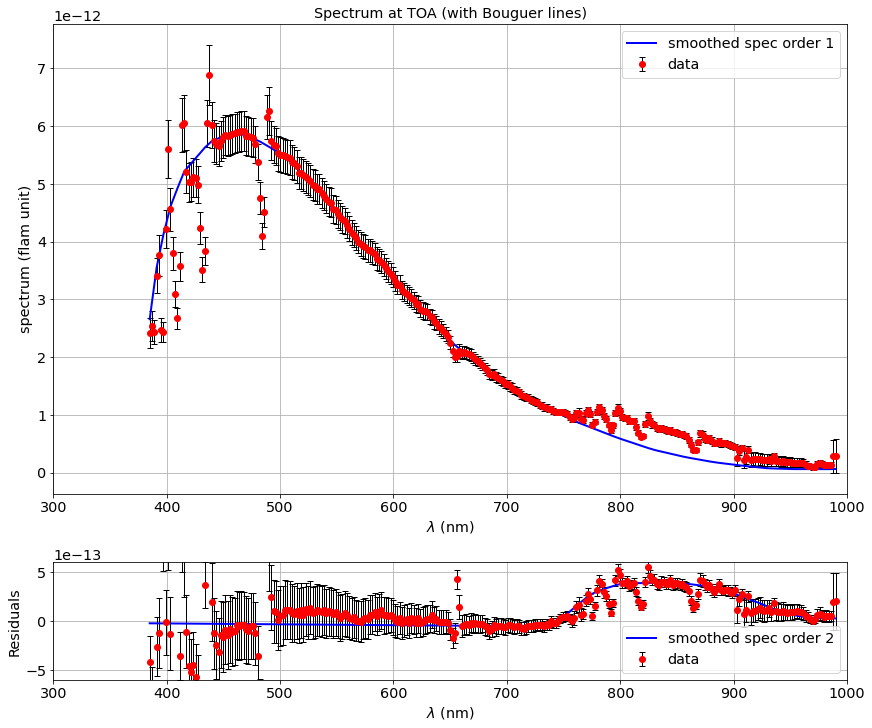

In [50]:
fig=plt.figure(figsize=(12,10),constrained_layout=True)


widths = [1,1]
heights = [4,1]
#spec = fig.add_gridspec(ncols=1, nrows=2, width_ratios=widths,height_ratios=heights)
spec = fig.add_gridspec(ncols=1, nrows=2, height_ratios=heights)

ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])

# top panel
ax1.errorbar(wl1,Y1,yerr=EY1,  fmt = 'o', color="r",capsize = 3, ecolor = 'k', elinewidth = 1, capthick = 1,label="data")
ax1.plot(x_spec,fcn_scan1(x_spec),'b-',label="smoothed spec order 1",lw=2)

ax1.set_xlabel("$\lambda$ (nm)")
ax1.set_ylabel("spectrum (flam unit)")
title=f"Spectrum at TOA (with Bouguer lines)"
ax1.set_title(title)
ax1.legend()
ax1.grid()
ax1.set_xlim(300,1000)
#ax.set_yscale("log")

# bottom panel

# interpolate the simulated spectrum

func_obs = interpolate.interp1d(obs.binwave/10, obs.binflux*10)

DeltaY1= Y1-func_obs(wl1) 
ax2.errorbar(wl1,DeltaY1,yerr=EY1,  fmt = 'o', color="r",capsize = 3, ecolor = 'k', elinewidth = 1, capthick = 1,label="data")
ax2.set_xlabel("$\lambda$ (nm)")
ax2.set_ylabel("Residuals")
ax2.plot(x_spec,fcn_scan2(x_spec),'b-',label="smoothed spec order 2",lw=2)
title=f"residuals"
#ax2.set_title(title)
ax2.legend()
ax2.grid()
ax2.set_xlim(300,1000)
ax2.set_ylim(-0.6e-12,0.6e-12)

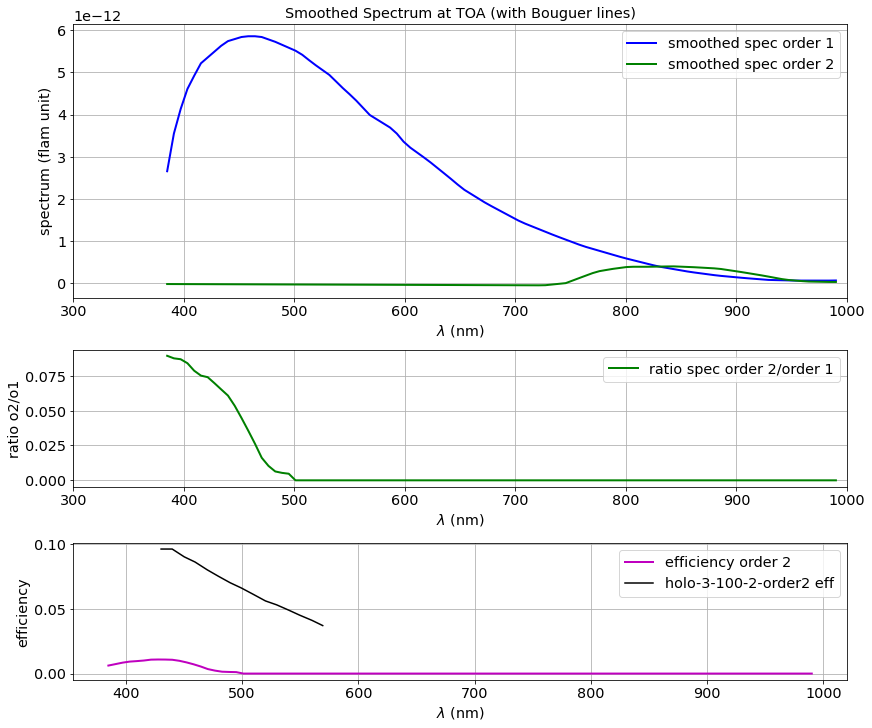

In [51]:
fig=plt.figure(figsize=(12,10),constrained_layout=True)


widths = [1,1]
heights = [2,1,1]
#spec = fig.add_gridspec(ncols=1, nrows=2, width_ratios=widths,height_ratios=heights)
spec = fig.add_gridspec(ncols=1, nrows=3, height_ratios=heights)

ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])

# top panel

ax1.plot(x_spec,fcn_scan1(x_spec),'b-',label="smoothed spec order 1",lw=2)
ax1.plot(x_spec,fcn_scan2(x_spec),'g-',label="smoothed spec order 2",lw=2)

ax1.set_xlabel("$\lambda$ (nm)")
ax1.set_ylabel("spectrum (flam unit)")
title=f"Smoothed Spectrum at TOA (with Bouguer lines)"
ax1.set_title(title)
ax1.legend()
ax1.grid()
ax1.set_xlim(300,1000)
#ax.set_yscale("log")

# middle panel

# interpolate the simulated spectrum
ratio=fcn_scan2(2*x_spec)/fcn_scan1(x_spec)
ax2.plot(x_spec,ratio,'g-',label="ratio spec order 2/order 1",lw=2)
ax2.set_xlabel("$\lambda$ (nm)")
ax2.set_ylabel("ratio o2/o1")
ax2.legend()

ax2.grid()
ax2.set_xlim(300,1000)
#ax2.set_ylim(-0.6e-12,0.6e-12)

# bottom pannel
y_spl=spl_thr(x_spec)

ax3.plot(x_spec,ratio*y_spl,'m-',label="efficiency order 2",lw=2)
if 1:
    #ax.plot(holodata4[:,1],holodata3[:,2],"g-",label=holotag4 )
    ax3.plot(holodata5[:,1],holodata5[:,2],"k-",label=holotag5 )

ax3.set_xlabel("$\lambda$ (nm)")
ax3.set_ylabel("efficiency")
ax3.grid()
ax3.legend()



# Gaussian fit

In [52]:
idx_wl=np.where(wl1<750)[0]

In [53]:
x_to_fit=wl1[idx_wl]
y_to_fit=Y1[idx_wl]
ey_to_fit=EY1[idx_wl]

In [54]:
my_kernel=1e-24 * RBF(length_scale=100.0, length_scale_bounds=(100, 500.0))+WhiteKernel(noise_level=1e-26, noise_level_bounds=(1e-26, 1e-25))

In [55]:
gp = GaussianProcessRegressor(kernel=my_kernel,normalize_y=True,alpha=(5*ey_to_fit)**2,n_restarts_optimizer=10)


## Prior

In [56]:
X_ = np.linspace(x_to_fit.min(), x_to_fit.max(), 200)

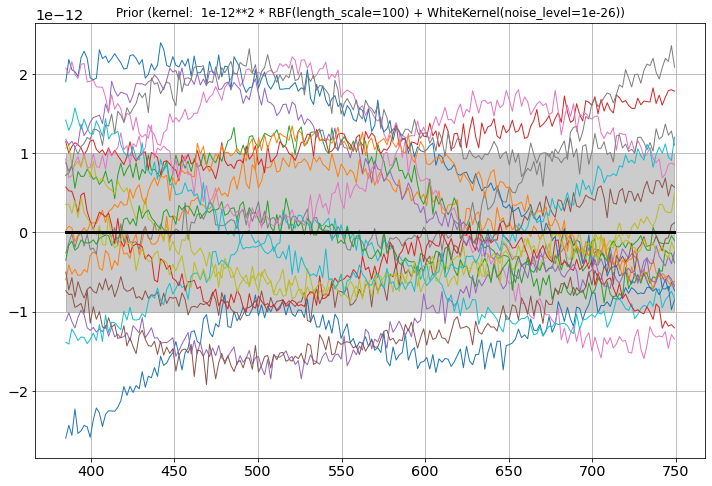

In [57]:

# Plot prior
fig=plt.figure()
fig.add_subplot(111)

y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - y_std, y_mean + y_std,alpha=0.2, color='k')
y_samples = gp.sample_y(X_[:, np.newaxis], 20)
plt.plot(X_, y_samples, lw=1)
plt.title("Prior (kernel:  %s)" % my_kernel, fontsize=12)
plt.grid()

## Gaussian fit

In [58]:
#gp.fit(x_to_fit[:, np.newaxis], y_to_fit)
#y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)

## Spline

In [59]:
spl = UnivariateSpline(x_to_fit, y_to_fit)
spl.set_smoothing_factor(10)

## Plot

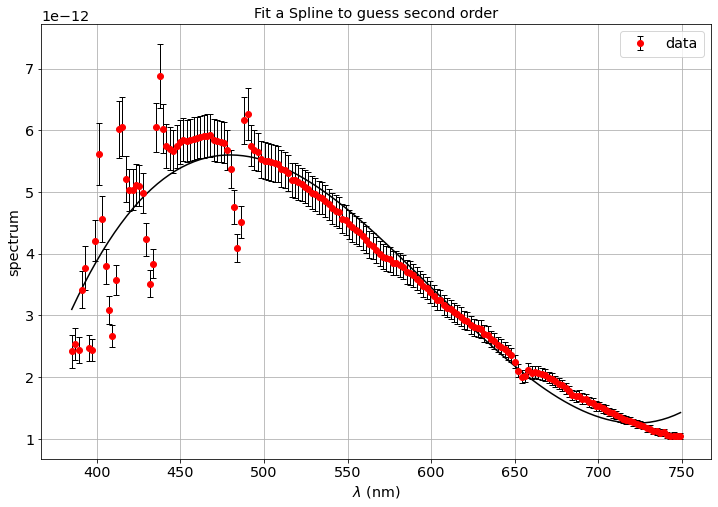

In [60]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.errorbar(x_to_fit,y_to_fit,yerr=ey_to_fit,  fmt = 'o', color="r",capsize = 3, ecolor = 'k', elinewidth = 1, capthick = 1,label="data")

#ax.plot(X_, y_mean, 'k', lw=3, zorder=9)
#ax.fill_between(X_, y_mean - y_std, y_mean + y_std,alpha=0.2, color='k')

ax.plot(X_,spl(X_),"k-")

ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("spectrum")
title=f"Fit a Spline to guess second order"
ax.set_title(title)
ax.legend()
ax.grid()
#ax.set_yscale("log"

In [61]:
fcn3 = interpolate.interp1d(2*wl2,spl(wl2)/2,bounds_error=False,fill_value=(0,0))

In [62]:
Y3interp=fcn3(wl1) 

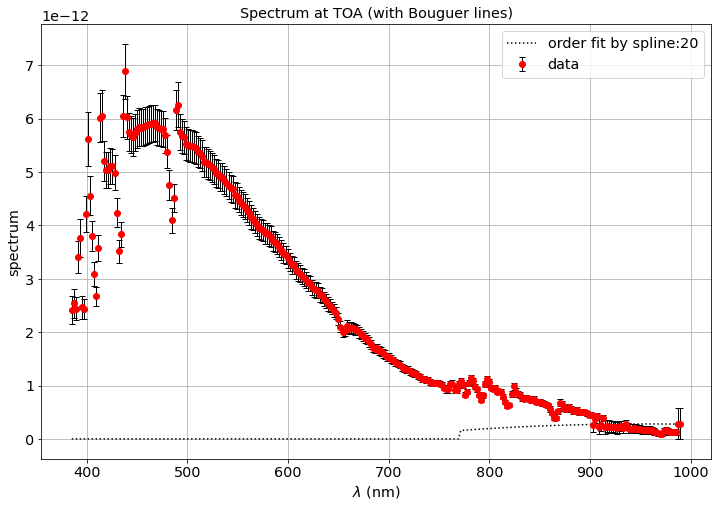

In [63]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.errorbar(wl1,Y1,yerr=EY1,  fmt = 'o', color="r",capsize = 3, ecolor = 'k', elinewidth = 1, capthick = 1,label="data")
#ax.errorbar(w_s,transm_s,yerr=em_s,  fmt = 'o', color="r",ecolor = 'k', elinewidth = 1)
#ax.plot(w,transm,"or")

ax.plot(wl1,Y3interp/10,"k:",label="order fit by spline:20")
#plt.plot(sed_w,sed_f,"b-",label="SED")
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("spectrum")
title=f"Spectrum at TOA (with Bouguer lines)"
ax.set_title(title)
ax.legend()
ax.grid()
#ax.set_yscale("log")